### <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## <font style="color:green"> Imports

In [29]:
import os
import time
from dataclasses import dataclass
from typing import List, Union, Tuple

import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch as torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.utils as utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms
import torchvision.models as models

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

from tqdm import tqdm  # For progress bar

# Text formatting
bold = "\033[1m"
end = "\033[0m"

plt.style.use('ggplot')
block_plot=False

%matplotlib inline

In [30]:
#!pip install efficientnet_pytorch 
#from efficientnet_pytorch import EfficientNet

## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    

```


```python
def get_data(args1, *args):
    ....
    ....
    return train_loader, test_loader
```

### <font style="color:purple">Prepare Data

Splits data into 80/20 Train and Valid datasets and saves them.

In [31]:
class KenyanFood13Dataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image IDs and labels.
            img_dir (str): Directory where images are stored.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.data = pd.read_csv(csv_file)  # Load CSV file
        self.img_dir = img_dir
        self.transform = transform
        
        # Convert class labels to numerical values if they are categorical
        self.class_to_idx = {label: idx for idx, label in enumerate(sorted(self.data['class'].unique()))}
        self.data['class_idx'] = self.data['class'].map(self.class_to_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, str(self.data.iloc[idx, 0]) + ".jpg")  # Get image filename from CSV
        image = Image.open(img_name).convert('RGB')  # Open image
        
        label = int(self.data.iloc[idx, 2])  # Get the class index (numerical label)
        
        if self.transform:
            image = self.transform(image)  # Apply transformations
            
        return image, label

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 (for CNN models)
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])

In [32]:
def get_data(csv_file, img_dir, batch_size=32, train_split=0.8, transform=None):
    """
    Args:
        csv_file (str): Path to the CSV file containing image filenames and labels.
        img_dir (str): Path to the directory where images are stored.
        batch_size (int): Number of samples per batch.
        train_split (float): Percentage of data to be used for training (default: 80%).
        transform (callable, optional): Transformations to apply to the images.

    Returns:
        train_loader (DataLoader): DataLoader for training set.
        test_loader (DataLoader): DataLoader for test/validation set.
    """
    # Load the full dataset
    full_dataset = KenyanFood13Dataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

    # Split dataset into training and testing sets
    train_size = int(train_split * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [33]:
# File paths
csv_file = "/kaggle/input/opencv-pytorch-project-2-classification-round-3/train.csv"
img_dir = "/kaggle/input/opencv-pytorch-project-2-classification-round-3/images/images"

# Load DataLoaders
train_loader, test_loader = get_data(csv_file, img_dir, batch_size=32, transform=transform)

# Check a sample batch
images, labels = next(iter(train_loader))
print(f"Batch size: {len(images)}, Image shape: {images[0].shape}, Labels: {labels[:5]}")

Batch size: 32, Image shape: torch.Size([3, 224, 224]), Labels: tensor([10,  1,  5,  7,  7])


## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/opencv-pytorch-project-2-classification-round-3" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

### <font style="color:pink">System Configuration

In [34]:
@dataclass
class SystemConfig:
    """
    Describes the common system setting needed for reproducible training
    """

    seed: int = 42  # A more widely used seed value for better reproducibility
    cudnn_benchmark_enabled: bool = True  # Keep enabled for performance boost
    cudnn_deterministic: bool = False  # Set False for better GPU optimization

### <font style="color:pink">Training Configuration

In [35]:
@dataclass
class TrainingConfig:
    """
    Describes configuration of the training process
    """

    num_classes: int = 13
    batch_size: int = 32  # Increased batch size for stable gradient updates
    img_size: Tuple = (224, 224)  # Use standard size for better feature extraction
    epochs_count: int = 20  # Increase epochs for better learning
    init_learning_rate: float = 0.0005  # Lower learning rate for stable convergence
    data_root: str = "/kaggle/input/opencv-pytorch-project-2-classification-round-3"
    working_data_root: str = "/kaggle/working"
    num_workers: int = 4  # Increase workers for faster data loading
    device: str = "cuda"  # Keep it on GPU

    # For tensorboard logging and saving checkpoints
    save_model_name: str = "kenyan_food_classifier.pt"
    root_log_dir: str = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir: str = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir: str = "version_1"  # Update version for tracking improvements
    checkpoint_dir: str = "version_1"

### <font style="color:pink">System Setup

In [36]:
def setup_system(system_config: SystemConfig) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

## <font style="color:purple">Model Evaluator

In [37]:
class ModelEvaluator:
    def __init__(self, model, dataloader, device):
        """
        Args:
            model (torch.nn.Module): The trained PyTorch model.
            dataloader (DataLoader): DataLoader for evaluation dataset.
            device (str): 'cuda' or 'cpu'.
        """
        self.model = model.to(device)
        self.dataloader = dataloader
        self.device = device

    def evaluate(self):
        """
        Evaluates the model on the dataset.
        
        Returns:
            dict: Dictionary containing accuracy, precision, recall, F1-score.
        """
        self.model.eval()  # Set model to evaluation mode

        all_preds = []
        all_labels = []

        with torch.no_grad():  # Disable gradient computation for evaluation
            for images, labels in self.dataloader:
                images, labels = images.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(images)
                _, preds = torch.max(outputs, 1)  # Get predicted class (argmax)

                all_preds.extend(preds.cpu().numpy())  # Convert to NumPy
                all_labels.extend(labels.cpu().numpy())

        # Compute metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        conf_matrix = confusion_matrix(all_labels, all_preds)

        results = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "Confusion Matrix": conf_matrix
        }

        return results

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

In [38]:
# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    model.to(device)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training Phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # Validation Phase
        val_loss, val_acc = validate_model(model, val_loader, criterion, device)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Step the scheduler after each epoch
        scheduler.step()

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}\n")

    return history

In [39]:
# Validation Function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    return val_loss, val_acc

## Example Use 

In [40]:
# Set device
# = "cuda" if torch.cuda.is_available() else "cpu"

# Define model, loss function, and optimizer
#model = MyCustomModel()  # Replace with your model
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and validate the model
#history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

### <font style="color:lightgreen">Main Function for Training

## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

### <font style="color:brown">Models

In [41]:
# Define a CNN Model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),  # Assuming input size is 224x224
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x

In [42]:
def get_resnet50_model(num_classes, device):
    """
    Loads a pretrained ResNet50 model for better accuracy.
    """
    model = models.resnet50(pretrained=True)  # Load pretrained weights
    num_features = model.fc.in_features  # Get input size of the last layer

    # Unfreeze last few layers
    for param in model.layer4.parameters():  # Unfreeze last ResNet block
        param.requires_grad = True

    # Replace final classification layer with a new one
    # Replace the FC layer with a custom classifier
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.4),  # High dropout rate since ResNet50 is strong
        nn.Linear(1024, num_classes)
    )

    return model.to(device)

In [43]:
#!pip install efficientnet_pytorch

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [44]:
#from efficientnet_pytorch import EfficientNet
#import torch.nn as nn
#import torch

def get_efficient_net(num_classes, device):
    """
    Loads a pretrained EfficientNet-B3 model with fine-tuning of deeper layers.
    """
    model = EfficientNet.from_pretrained('efficientnet-b3')  # Load EfficientNet-B3

    # Unfreeze last 3 blocks for fine-tuning (More Learnable Layers)
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers first

    for param in model._blocks[-3:].parameters():  # Unfreeze last 3 blocks
        param.requires_grad = True

    # Modify the classifier to match the number of classes
    num_features = model._fc.in_features
    model._fc = nn.Sequential(
        nn.Linear(num_features, 1024),  # Increase FC Layer Size
        nn.BatchNorm1d(1024),           # Normalize before activation
        nn.ReLU(),
        nn.Dropout(0.4),                # Increase Dropout for Regularization
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)  # Output layer
    )

    return model.to(device)


## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

### <font style="color:purple"> Common Image Transforms

In [72]:
def image_preprocess_transforms(img_size):
    preprocess = transforms.Compose(
        [
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ]
    )

    return preprocess

In [73]:
def image_common_transforms(img_size=(224, 224), mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms(img_size)

    common_transforms = transforms.Compose(
        [
            preprocess,
            transforms.Normalize(mean, std),
        ]
    )

    return common_transforms

### <font style="color:purple"> System Config

In [45]:
def setup_system(system_config: SystemConfig) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

### <font style="color:purple"> Save & Load Model

In [46]:
def save_model(model, device, model_dir="models", model_file_name="kenyan_food_classifier.pt"):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # Make sure you transfer the model to cpu.
    if device == "cuda":
        model.to("cpu")

    # Save the 'state_dict'
    torch.save(model.state_dict(), model_path)

    if device == "cuda":
        model.to("cuda")

    return

In [47]:
def load_model(model, model_dir="models", model_file_name="kenyan_food_classifier.pt", device=torch.device("cpu")):
    model_path = os.path.join(model_dir, model_file_name)

    # Load model parameters by using 'load_state_dict'.
    model.load_state_dict(torch.load(model_path, map_location=device))

    return model

### <font style="color:purple"> Get Mean and Std

In [48]:
def get_mean_std(loader, img_size=(224, 224), num_workers=4):

    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)

    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3))  # E[batch_i]
        batch_mean_sqrd += (batch_data**2).mean(dim=(0, 2, 3))  #  E[batch_i**2]

    # E[dataset] = E[E[batch_1], E[batch_2], ...]
    mean = batch_mean / len(loader)

    # var[X] = E[X**2] - E[X]**2

    # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2

    var = (batch_mean_sqrd / len(loader)) - (mean**2)

    std = var**0.5
    print("mean: {}, std: {}".format(mean, std))

    return mean, std

### <font style="color:purple"> Logging Setup

In [49]:
def setup_log_directory(training_config=TrainingConfig()):
    """Tensorboard Log and Model checkpoint directory Setup"""

    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir.
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(training_config.root_log_dir)]

        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = training_config.log_dir

    # Update the training config default directory.
    training_config.log_dir = os.path.join(training_config.root_log_dir, version_name)
    training_config.checkpoint_dir = os.path.join(training_config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version.
    os.makedirs(training_config.log_dir, exist_ok=True)
    os.makedirs(training_config.checkpoint_dir, exist_ok=True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_dir}")

    return training_config, version_name

### <font style="color:purple"> Plot Loss and Accuracy
The next code cell will focus on developing a function for plotting loss and accuracy graphs. This function is instrumental in visualizing the performance of the deep learning model throughout the training process, providing insights into its learning behavior by displaying trends in loss reduction and accuracy improvement over epochs.

In [50]:
def plot_loss_accuracy(
    train_loss,
    val_loss,
    train_acc,
    val_acc,
    colors,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(20, 10),
    sub_plot1=(1, 2, 1),
    sub_plot2=(1, 2, 2),
):
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = min(train_loss[i])
        min_val_loss = min(val_loss[i])

        plt.plot(x_train, train_loss[i], linestyle="-", color=f"tab:{colors[i]}", label=f"TRAIN LOSS ({min_train_loss:.4})")
        plt.plot(x_val, val_loss[i], linestyle="--", color=f"tab:{colors[i]}", label=f"VALID LOSS ({min_val_loss:.4})")


    plt.xlabel("epoch no.")
    plt.ylabel("loss")
    plt.legend(loc=loss_legend_loc)
    plt.title("Training and Validation Loss")
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = max(train_acc[i])
        max_val_acc = max(val_acc[i])

        plt.plot(
            x_train,
            train_acc[i],
            linestyle="-",
            color=f"tab:{colors[i]}",
            label=f"TRAIN ACC ({max_train_acc:.4})",
        )

        plt.plot(
            x_val,
            val_acc[i],
            linestyle="--",
            color=f"tab:{colors[i]}",
            label=f"VALID ACC ({max_val_acc:.4})",
        )


    plt.xlabel("epoch no.")
    plt.ylabel("accuracy")
    plt.legend(loc=acc_legend_loc)
    plt.title("Training and Validation Accuracy")
    fig.savefig("sample_loss_acc_plot.png")
    plt.show()

    return

### <font style="color:purple">Sample Prediction

In [51]:
def prediction(model, device, batch_input):
    data = batch_input.to(device)

    with torch.no_grad():
        output = model(data)

    # Score to probability using softmax.
    prob = F.softmax(output, dim=1)

    # Get the max probability.
    pred_prob = prob.data.max(dim=1)[0]

    # Get the index of the max probability.
    pred_index = prob.data.max(dim=1)[1]

    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

### <font style="color:purple">Get Predictions on a Batch

## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

In [53]:
def main(model, summary_writer, scheduler=None, system_config=SystemConfig(), training_config=TrainingConfig(), data_augmentation=True):

    # Setup system configuration.
    setup_system(system_config)
    
    # Set device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # File paths for dataset
    csv_file = "/kaggle/input/opencv-pytorch-project-2-classification-round-3/train.csv"
    img_dir = "/kaggle/input/opencv-pytorch-project-2-classification-round-3/images/images"

    # Define transformations (ensure this is compatible with your dataset)
    transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load Data
    train_loader, val_loader = get_data(csv_file, img_dir, batch_size=32, transform=transform)

    # Get number of classes from CSV
    num_classes = len(pd.read_csv(csv_file)['class'].unique())
    
    # Define Model, Loss, and Optimizer
    #model = CustomCNN(num_classes=num_classes).to(device)
    model = get_resnet50_model(num_classes, device)
    #model = get_efficient_net(num_classes, device)
    
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)  # AdamW is better for generalization
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs
    

    # Train Model
    print("Starting training...")
    history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=training_config.epochs_count, device=device)

    # Save Model
    save_model(model, device)

    return model, history

In [67]:
def get_sample_prediction(model, data_root, img_size, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    # It is important to do model.eval() before prediction.
    model.eval()

    # Send model to cpu/cuda according to your system configuration.
    model.to(device)

    # Transformed data
    test_csv = data_root
    img_dir = Path("/kaggle/input/opencv-pytorch-project-2-classification-round-3/images/images")

    valid_dataset_trans = KenyanFood13Dataset(csv_file=test_csv, img_dir=img_dir, transform=image_common_transforms(img_size, mean, std))

    # Original image dataset
    valid_dataset = KenyanFood13Dataset(csv_file=test_csv, img_dir=img_dir, transform=image_common_transforms(img_size, mean, std))


    # Load the full dataset
    #full_dataset = KenyanFood13Dataset(csv_file=csv_file, img_dir=img_dir, transform=image_common_transforms(img_size, mean, std))

    # Split dataset into training and testing sets
    #train_size = int(train_split * len(full_dataset))
    #test_size = len(full_dataset) - train_size
    #train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

    # Create DataLoaders
    #train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    #test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



    
    data_len = valid_dataset.__len__()

    interval = int(data_len / batch_size)

    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = valid_dataset_trans.__getitem__(index)
        img, _ = valid_dataset.__getitem__(index)

        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)

    inputs = torch.stack(inputs)

    cls, prob = prediction(model, device, batch_input=inputs)

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()

    for i, target in enumerate(targets):
        plt.subplot(3, 5, i + 1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title(f"P:{valid_dataset.classes[cls[i]]}({prob[i]:.2}), T:{valid_dataset.classes[targets[i]]}")
    plt.show()

    return


In [54]:
#!pip install efficientnet_pytorch

## <font style="color:olive">Training

In [55]:
#from efficientnet_pytorch import EfficientNet

model = get_resnet50_model(num_classes = 13, device = "cuda" if torch.cuda.is_available() else "cpu")
#model = get_efficient_net(num_classes = 13, device = "cuda" if torch.cuda.is_available() else "cpu")

print(model)

training_config = TrainingConfig()

# Model checkpoint log dir setup.
training_config, current_version_name = setup_log_directory(training_config)

# Tensorboard log dir setup.
summary_writer = SummaryWriter(training_config.log_dir)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [56]:
#Define an optimizer before the scheduler
# Use Advanced Optimizer & Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs
# Cosine Annealing (Prevents sudden drop in accuracy)
scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)  # Adjust LR dynamically

# Train and Validate
model, history = main(
    model,
    summary_writer=summary_writer,
    scheduler=scheduler,  #Use learning rate scheduler
    system_config=SystemConfig(),
    training_config=training_config,
    data_augmentation=True,
)


# Extract loss and accuracy history
train_loss = history["train_loss"]
train_acc = history["train_acc"]
val_loss = history["val_loss"]
val_acc = history["val_acc"]

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch 1/30


Validating: 100%|██████████| 41/41 [00:51<00:00,  1.25s/it]


Train Loss: 1.6962 | Train Acc: 0.4755
Val Loss: 1.6451 | Val Acc: 0.5161

Epoch 2/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.06it/s]


Train Loss: 1.4751 | Train Acc: 0.5369
Val Loss: 1.4392 | Val Acc: 0.5573

Epoch 3/30


Validating: 100%|██████████| 41/41 [00:37<00:00,  1.08it/s]


Train Loss: 1.3619 | Train Acc: 0.5765
Val Loss: 1.4516 | Val Acc: 0.5596

Epoch 4/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.08it/s]


Train Loss: 1.2856 | Train Acc: 0.6004
Val Loss: 1.2800 | Val Acc: 0.5902

Epoch 5/30


Validating: 100%|██████████| 41/41 [00:37<00:00,  1.09it/s]


Train Loss: 1.2368 | Train Acc: 0.6117
Val Loss: 1.3221 | Val Acc: 0.5872

Epoch 6/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.08it/s]


Train Loss: 1.0380 | Train Acc: 0.6750
Val Loss: 1.0562 | Val Acc: 0.6720

Epoch 7/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.08it/s]


Train Loss: 0.9573 | Train Acc: 0.6901
Val Loss: 1.0356 | Val Acc: 0.6865

Epoch 8/30


Validating: 100%|██████████| 41/41 [00:37<00:00,  1.09it/s]


Train Loss: 0.9142 | Train Acc: 0.7024
Val Loss: 1.0427 | Val Acc: 0.6697

Epoch 9/30


Validating: 100%|██████████| 41/41 [00:36<00:00,  1.11it/s]


Train Loss: 0.8903 | Train Acc: 0.7175
Val Loss: 1.0458 | Val Acc: 0.6743

Epoch 10/30


Validating: 100%|██████████| 41/41 [00:35<00:00,  1.14it/s]


Train Loss: 0.8511 | Train Acc: 0.7269
Val Loss: 0.9998 | Val Acc: 0.6835

Epoch 11/30


Validating: 100%|██████████| 41/41 [00:36<00:00,  1.14it/s]


Train Loss: 0.8298 | Train Acc: 0.7408
Val Loss: 1.0310 | Val Acc: 0.6797

Epoch 12/30


Validating: 100%|██████████| 41/41 [00:36<00:00,  1.12it/s]


Train Loss: 0.7915 | Train Acc: 0.7433
Val Loss: 1.0030 | Val Acc: 0.6820

Epoch 13/30


Validating: 100%|██████████| 41/41 [00:37<00:00,  1.10it/s]


Train Loss: 0.7935 | Train Acc: 0.7402
Val Loss: 0.9586 | Val Acc: 0.7003

Epoch 14/30


Validating: 100%|██████████| 41/41 [00:37<00:00,  1.09it/s]


Train Loss: 0.7888 | Train Acc: 0.7496
Val Loss: 1.0041 | Val Acc: 0.6873

Epoch 15/30


Validating: 100%|██████████| 41/41 [00:37<00:00,  1.11it/s]


Train Loss: 0.7695 | Train Acc: 0.7651
Val Loss: 1.0204 | Val Acc: 0.6865

Epoch 16/30


Validating: 100%|██████████| 41/41 [00:36<00:00,  1.12it/s]


Train Loss: 0.7704 | Train Acc: 0.7544
Val Loss: 0.9908 | Val Acc: 0.6995

Epoch 17/30


Validating: 100%|██████████| 41/41 [00:36<00:00,  1.13it/s]


Train Loss: 0.7596 | Train Acc: 0.7571
Val Loss: 0.9899 | Val Acc: 0.6957

Epoch 18/30


Validating: 100%|██████████| 41/41 [00:36<00:00,  1.13it/s]


Train Loss: 0.7842 | Train Acc: 0.7531
Val Loss: 0.9494 | Val Acc: 0.7087

Epoch 19/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.07it/s]


Train Loss: 0.7847 | Train Acc: 0.7508
Val Loss: 0.9653 | Val Acc: 0.6995

Epoch 20/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.06it/s]


Train Loss: 0.7812 | Train Acc: 0.7510
Val Loss: 0.9511 | Val Acc: 0.6972

Epoch 21/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.05it/s]


Train Loss: 0.7904 | Train Acc: 0.7513
Val Loss: 0.9836 | Val Acc: 0.6980

Epoch 22/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.06it/s]


Train Loss: 0.7690 | Train Acc: 0.7603
Val Loss: 0.9702 | Val Acc: 0.6927

Epoch 23/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.07it/s]


Train Loss: 0.7820 | Train Acc: 0.7582
Val Loss: 0.9827 | Val Acc: 0.7080

Epoch 24/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.07it/s]


Train Loss: 0.7806 | Train Acc: 0.7544
Val Loss: 0.9642 | Val Acc: 0.7003

Epoch 25/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.06it/s]


Train Loss: 0.7755 | Train Acc: 0.7519
Val Loss: 0.9912 | Val Acc: 0.7018

Epoch 26/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.07it/s]


Train Loss: 0.7645 | Train Acc: 0.7584
Val Loss: 1.0184 | Val Acc: 0.6820

Epoch 27/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.06it/s]


Train Loss: 0.7582 | Train Acc: 0.7550
Val Loss: 0.9581 | Val Acc: 0.7080

Epoch 28/30


Validating: 100%|██████████| 41/41 [00:39<00:00,  1.05it/s]


Train Loss: 0.7754 | Train Acc: 0.7575
Val Loss: 0.9901 | Val Acc: 0.6881

Epoch 29/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.07it/s]


Train Loss: 0.7855 | Train Acc: 0.7454
Val Loss: 0.9830 | Val Acc: 0.7011

Epoch 30/30


Validating: 100%|██████████| 41/41 [00:38<00:00,  1.07it/s]


Train Loss: 0.7688 | Train Acc: 0.7492
Val Loss: 0.9326 | Val Acc: 0.7194



## <font style="color:olive">Load Model and Run Inference

In [78]:
import pandas as pd

def get_class_names(csv_file):
    """
    Extract unique class names from the 'class' column in a CSV file.

    Parameters:
        csv_file (str): Path to the CSV file containing the 'class' column.

    Returns:
        list: Sorted list of unique class names.
    """
    df = pd.read_csv(csv_file)  # Load CSV file
    class_names = df["class"].unique().tolist()  # Extract unique class labels
    return sorted(class_names)  # Return sorted class names

In [95]:
import os
import torch
import pandas as pd
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset

class CustomTestDataset(Dataset):
    """
    Custom Dataset for Test Images Without Labels.
    """
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)  # Load CSV file
        self.img_dir = img_dir  # Image directory
        self.transform = transform  # Transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = str(self.data.iloc[idx, 0]) + ".jpg" # Get image name from CSV
        img_path = os.path.join(self.img_dir, img_name)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations if given
        if self.transform:
            image = self.transform(image)

        return image, img_name  # Return image and its filename

In [91]:
def generate_predictions_02(model, csv_file, img_dir, img_size, mean, std, class_names, submission_file="submission.csv"):
    """
    Generate predictions using a custom test dataset with images in a single folder and labels in a CSV.

    Parameters:
        model (torch.nn.Module): Trained model.
        csv_file (str): Path to the CSV file containing image filenames.
        img_dir (str): Path to the folder containing all test images.
        img_size (tuple): Image size (height, width).
        mean (tuple): Mean values for normalization.
        std (tuple): Standard deviation values for normalization.
        class_names (list): List of class names.
        submission_file (str): File name for submission CSV.

    Returns:
        None
    """

    # Ensure model is in evaluation mode
    model.eval()
    device = next(model.parameters()).device  # Get model's device

    # Define preprocessing transformations
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Load custom dataset
    test_dataset = CustomTestDataset(csv_file, img_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # List to store results
    predictions = []

    with torch.no_grad():
        for images, img_names in test_loader:
            images = images.to(device)

            # Get model predictions
            output = model(images)
            predicted_label = torch.argmax(output, dim=1).item()
            predicted_class = class_names[predicted_label]

            # Store results
            predictions.append({"ID": img_names[0], "CLASS": predicted_class})

    # Save predictions to CSV
    submission_df = pd.DataFrame(predictions)
    submission_df.to_csv(submission_file, index=False)
    print(f"Predictions saved to {submission_file}")

In [96]:
# Define paths
csv_file = "/kaggle/input/opencv-pytorch-project-2-classification-round-3/test.csv"  # CSV containing image names
img_dir = "/kaggle/input/opencv-pytorch-project-2-classification-round-3/images/images"  # Folder with test images

# Define model & parameters
model = trained_model  # Assuming model is already loaded
img_size = (224, 224)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
train_csv_file = "/kaggle/input/opencv-pytorch-project-2-classification-round-3/train.csv"  # Update path
class_names = get_class_names(train_csv_file)
print(class_names)


# Generate Predictions
generate_predictions_02(model, csv_file, img_dir, img_size, mean, std, class_names)

['bhaji', 'chapati', 'githeri', 'kachumbari', 'kukuchoma', 'mandazi', 'masalachips', 'matoke', 'mukimo', 'nyamachoma', 'pilau', 'sukumawiki', 'ugali']
Predictions saved to submission.csv


### <font style="color:purple">Loss and Accuracy Plot

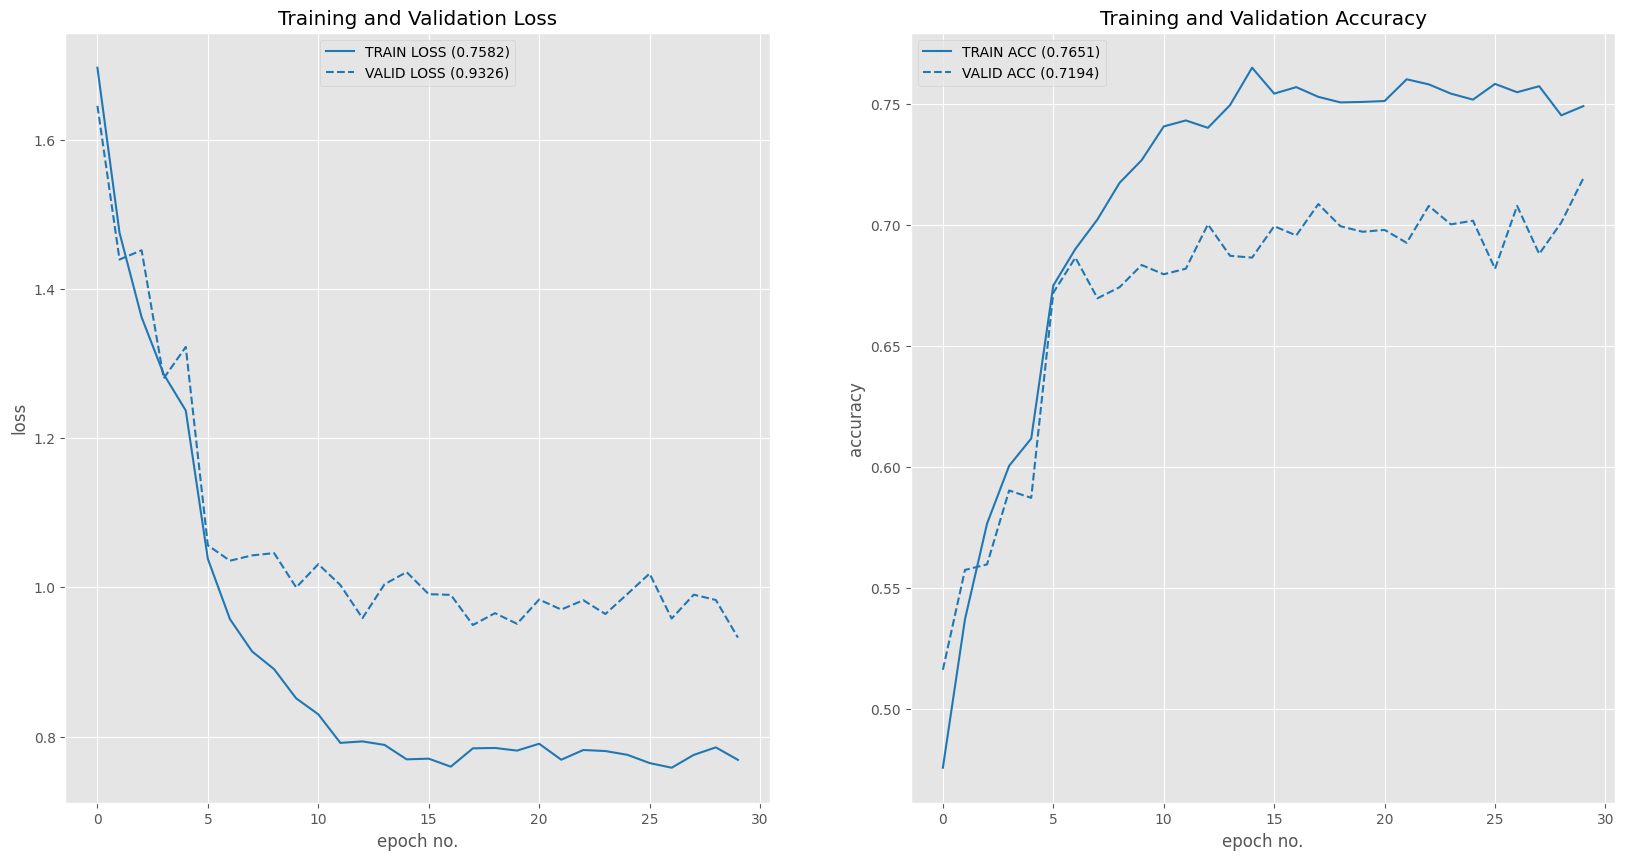

In [97]:
plot_loss_accuracy(
    train_loss=[train_loss],
    val_loss=[val_loss],
    train_acc=[train_acc],
    val_acc=[val_acc],
    colors=["blue"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

## <font style="color:green">8. TensorBoard Log Link [5 Points]</font>

**Share your TensorBoard scalars logs link here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


Note: In light of the recent shutdown of tensorboard.dev, we have updated the submission requirements for your project. Instead of sharing a tensorboard.dev link, you are now required to upload your generated TensorBoard event files directly onto the lab. As an alternative, you may also include a screenshot of your TensorBoard output within your Jupyter notebook. This adjustment ensures that your data visualization and model training efforts are thoroughly documented and accessible for evaluation.

You are also welcome (and encouraged) to utilize alternative logging services like wandB or comet. In such instances, you can easily make your project logs publicly accessible and share the link with others.

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**